In [1]:
import numpy as np
from collections import Counter

def entropy(y):
    counts = Counter(y)
    probabilities = [count / len(y) for count in counts.values()]
    return -sum(p * np.log2(p) for p in probabilities)


In [2]:
def information_gain(X, y, feature_index, threshold):
    parent_entropy = entropy(y)
    left_indices = X[:, feature_index] <= threshold
    right_indices = X[:, feature_index] > threshold
    if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
        return 0
    n = len(y)
    n_left, n_right = len(y[left_indices]), len(y[right_indices])
    weighted_entropy = (n_left / n) * entropy(y[left_indices]) + (n_right / n) * entropy(y[right_indices])
    gain = parent_entropy - weighted_entropy
    return gain


In [3]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def build_tree(X, y, depth=0, max_depth=None):
    if len(np.unique(y)) == 1 or (max_depth is not None and depth >= max_depth):
        leaf_value = Counter(y).most_common(1)[0][0]
        return Node(value=leaf_value)
    best_gain = -1
    best_index = None
    best_threshold = None
    n_features = X.shape[1]
    for feature_index in range(n_features):
        thresholds = np.unique(X[:, feature_index])
        for threshold in thresholds:
            gain = information_gain(X, y, feature_index, threshold)
            if gain > best_gain:
                best_gain = gain
                best_index = feature_index
                best_threshold = threshold
    if best_index is None:
        leaf_value = Counter(y).most_common(1)[0][0]
        return Node(value=leaf_value)
    left_indices = X[:, best_index] <= best_threshold
    right_indices = ~left_indices
    left_subtree = build_tree(X[left_indices], y[left_indices], depth + 1, max_depth)
    right_subtree = build_tree(X[right_indices], y[right_indices], depth + 1, max_depth)
    return Node(feature_index=best_index, threshold=best_threshold, left=left_subtree, right=right_subtree)


In [4]:
def predict_tree(node, x):
    if node.value is not None:
        return node.value
    if x[node.feature_index] <= node.threshold:
        return predict_tree(node.left, x)
    else:
        return predict_tree(node.right, x)

def predict(X, tree):
    return np.array([predict_tree(tree, x) for x in X])


In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

# 載入Iris數據集
iris = load_iris()
X, y = iris.data, iris.target

# 分割數據集為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 構建決策樹
dtree = build_tree(X_train, y_train, max_depth=4)

# 進行預測
y_pred = predict(X_test, dtree)

# 評估模型
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy:", accuracy)


Accuracy: 0.9555555555555556


In [6]:
def print_tree(node, depth=0):
    # 如果是葉節點，打印出值
    if node.value is not None:
        print(f"{'|   ' * depth}Predict: {node.value}")
        return
    
    # 如果不是葉節點，打印出特徵及其閾值
    print(f"{'|   ' * depth}Feature {node.feature_index} <= {node.threshold:.4f}")
    print(f"{'|   ' * depth}--> Left:")
    print_tree(node.left, depth + 1)
    print(f"{'|   ' * depth}--> Right:")
    print_tree(node.right, depth + 1)


In [7]:
# 使用已訓練的決策樹進行可視化
print_tree(dtree)


# 0 -> setosa: 山鳶尾
# 1 -> versicolor: 變色鳶尾
# 2 -> virginica: 維吉尼亞鳶尾


Feature 2 <= 1.9000
--> Left:
|   Predict: 0
--> Right:
|   Feature 2 <= 4.7000
|   --> Left:
|   |   Feature 3 <= 1.5000
|   |   --> Left:
|   |   |   Predict: 1
|   |   --> Right:
|   |   |   Predict: 2
|   --> Right:
|   |   Feature 2 <= 5.1000
|   |   --> Left:
|   |   |   Feature 3 <= 1.7000
|   |   |   --> Left:
|   |   |   |   Predict: 1
|   |   |   --> Right:
|   |   |   |   Predict: 2
|   |   --> Right:
|   |   |   Predict: 2


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, metrics
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn import tree



def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup markers generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 =  np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))

    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot all samples
    X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)
    
    # hightlight test samples
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', alpha=1.0, linewidth=1, marker='o', s=55, label='test set')

iris = datasets.load_iris()
x_train, x_test, y_train, y_test = train_test_split(iris.data[:, [2, 3]], iris.target, test_size=0.25, random_state=4)
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

X_combined = np.vstack((x_train, x_test))
y_combined = np.hstack((y_train, y_test))

# plot_decision_regions(X_combined, y_combined, classifier=clf)
# plt.xlabel('petal length [cm]')
# plt.ylabel('petal width [cm]')
# plt.legend(loc='upper left')
# plt.show()


In [9]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
print("Accuracy:", accuracy)


Accuracy: 0.9736842105263158


In [10]:
text_representation = tree.export_text(clf)
print(text_representation)


|--- feature_1 <= 0.80
|   |--- class: 0
|--- feature_1 >  0.80
|   |--- feature_1 <= 1.75
|   |   |--- feature_0 <= 4.95
|   |   |   |--- class: 1
|   |   |--- feature_0 >  4.95
|   |   |   |--- class: 2
|   |--- feature_1 >  1.75
|   |   |--- feature_0 <= 4.85
|   |   |   |--- class: 2
|   |   |--- feature_0 >  4.85
|   |   |   |--- class: 2



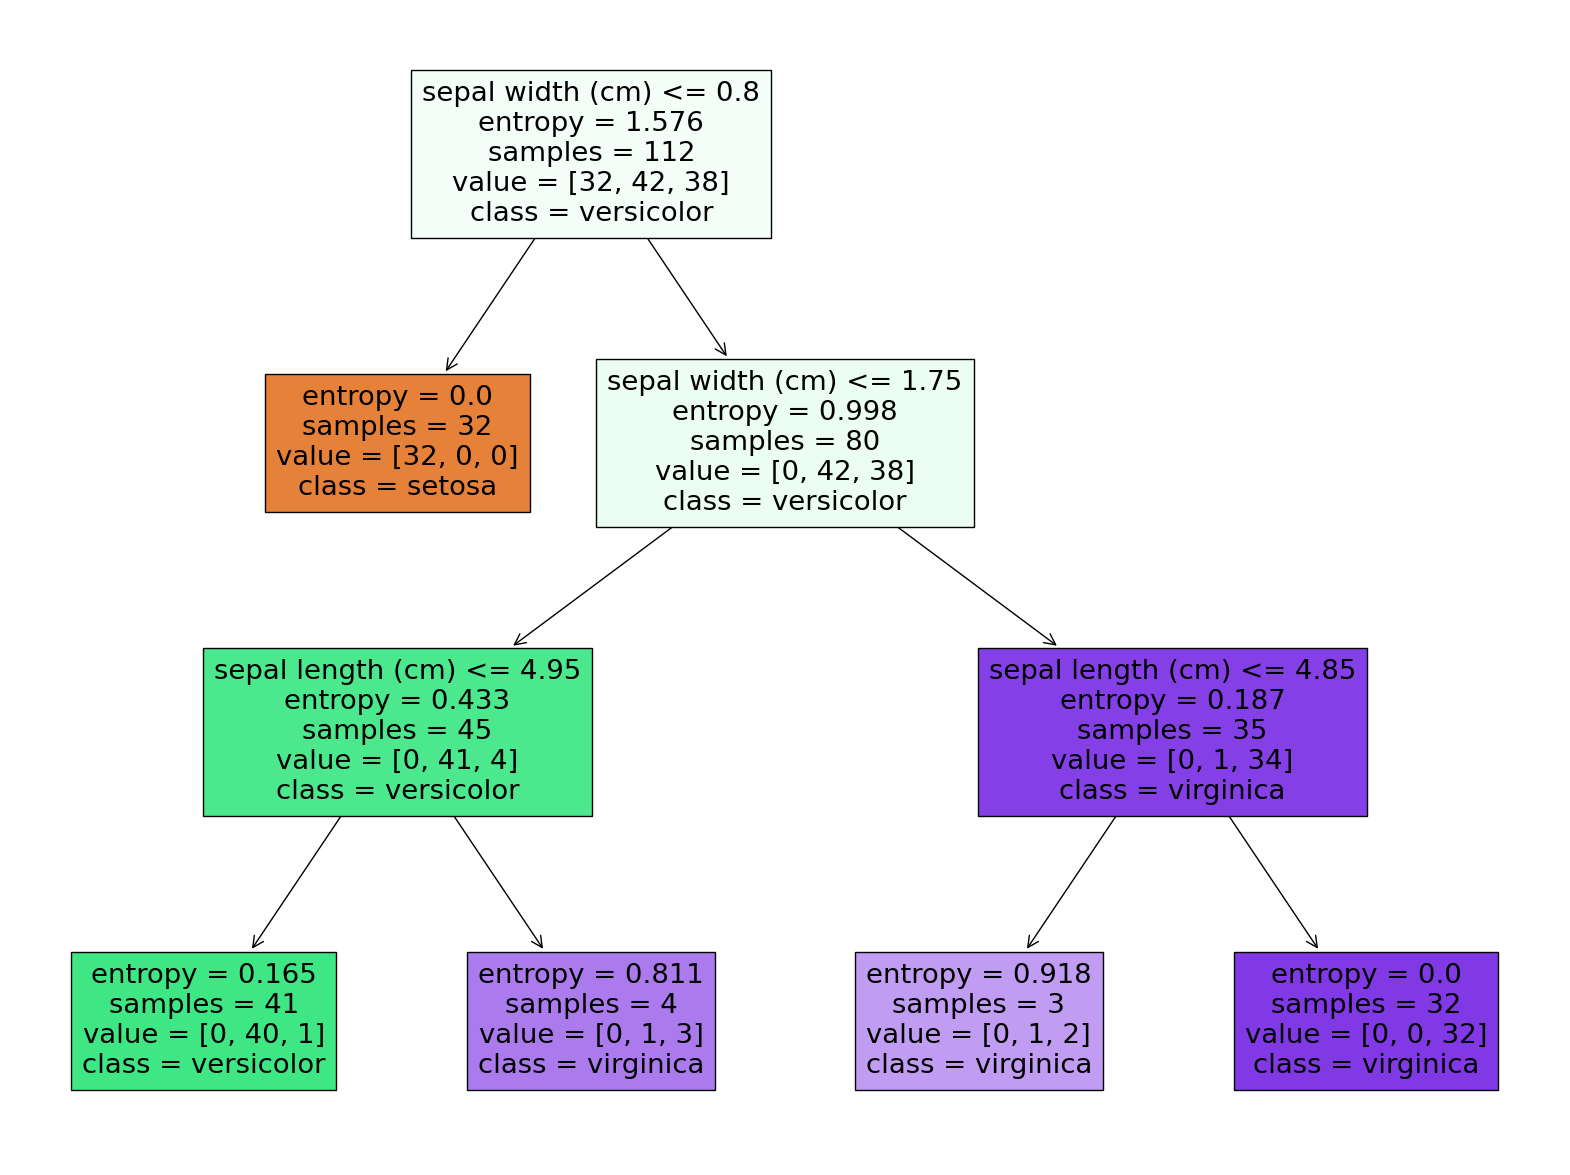

In [11]:
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(clf, 
                   feature_names=iris.feature_names,  
                   class_names=iris.target_names,
                   filled=True)
